In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.convnet import train_net, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

In [4]:
#import data for a 1000 pairs
N = 1000
dataset_train = DlDataset(N, normalize=True, upsample=None)
dataset_test = DlDataset(N, normalize=True, upsample=None)
dataset_train.train()
dataset_test.test()

datasetShape = list(dataset_train.__shape__()[1:])

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 linear layers, no batch norm
2. 2 conv layers, 2 batch norm layers, 2 linear layers
3. 3 conv layers, 2 linear layers, no batch norm
4. .... add architecture with dropout or ...

In [5]:
# The same net using NumNet class
# Dropout layer
# {'Type':'DropoutLayer', 'p':0.2}
models = []

# 2 convolutional layers followed by 2 linear layers
config_2c_2l = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2, 'activation':'LogSoftmax(dim=1)'}]
models.append(NumNet(datasetShape, config_2c_2l, name='2conv_2lin'))

# 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'BatchNormLayer'},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2, 'activation':'LogSoftmax(dim=1)'}]
models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_bnorm'))

# 3 convolutional layers followed by 2 linear layers
config_3c_2l = [{'Type': 'ConvLayer', 'out_channels':4, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
          {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
          {'Type': 'LinearLayer', 'out_features':2, 'activation':'LogSoftmax(dim=1)'}]
models.append(NumNet(datasetShape, config_3c_2l, name='3conv_2lin'))

# 2 convolutional layers with batch norm and 1 maxpool, followed by 2 linear layers 
config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':5},
          {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'ConvLayer', 'out_channels':64, 'activation':'ReLU()', 'kernel_size':3},
          #{'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
          {'Type': 'BatchNormLayer'},
          {'Type': 'LinearLayer', 'out_features':128, 'activation':'ReLU()'},
          #{'Type': 'DropoutLayer', 'p':0.5},
          {'Type': 'LinearLayer', 'out_features':2, 'activation':'LogSoftmax(dim=1)'}]
models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

for model in models:
    model.summary()

 
Model '2conv_2lin'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
2                   Linear              1024                32                  32800
3                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34442
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_bnorm'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16

In [6]:
# Train parameter
epochs = 30
mini_batch_size = 100
eta = 5e-2
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

criterion = torch.nn.CrossEntropyLoss()
dataloader = []
dataloader.append(DataLoader(dataset_train, batch_size=mini_batch_size,shuffle=True, num_workers=4))
dataloader.append(DataLoader(dataset_test, batch_size=mini_batch_size,shuffle=True, num_workers=4))

In [10]:
# Train each model with the same parameters
perf_summary = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
    #optim = torch.optim.Adam(model.parameters(), lr=0.001)
    performance, model = train_net(model, device, optim, criterion, dataloader,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    perf_summary.append(ModelPerformanceSummary(model, performance))

--------------------------------------------------
Running model: 2conv_2lin
--------------------------------------------------
Epoch 0: Duration: 0.34s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 1: Duration: 0.35s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 2: Duration: 0.38s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 3: Duration: 0.36s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 4: Duration: 0.34s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 5: Duration: 0.36s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 6: Duration: 0.36s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 7: Duration: 0.42s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 8: Duration: 0.34s, Train Loss: nan, Train Acc: 0.45, Val Loss: nan, Val Acc: 0.48
Epoch 9: Duration: 0.35s, Train Loss: nan, Train Acc: 0.45, Val Loss: n

Epoch 24: Duration: 0.39s, Train Loss: 4.03e-06, Train Acc: 1.00, Val Loss: 0.02, Val Acc: 0.74
Epoch 25: Duration: 0.45s, Train Loss: 3.86e-06, Train Acc: 1.00, Val Loss: 0.02, Val Acc: 0.74
Epoch 26: Duration: 0.37s, Train Loss: 3.71e-06, Train Acc: 1.00, Val Loss: 0.02, Val Acc: 0.74
Epoch 27: Duration: 0.40s, Train Loss: 3.57e-06, Train Acc: 1.00, Val Loss: 0.02, Val Acc: 0.74
Epoch 28: Duration: 0.40s, Train Loss: 3.42e-06, Train Acc: 1.00, Val Loss: 0.03, Val Acc: 0.74
Epoch 29: Duration: 0.38s, Train Loss: 3.29e-06, Train Acc: 1.00, Val Loss: 0.03, Val Acc: 0.74
--------------------------------------------------
Running model: 2conv_2lin_2bn_1do
--------------------------------------------------
Epoch 0: Duration: 0.47s, Train Loss: 2.22e-03, Train Acc: 0.92, Val Loss: 0.00, Val Acc: 0.80
Epoch 1: Duration: 0.49s, Train Loss: 1.61e-03, Train Acc: 0.94, Val Loss: 0.00, Val Acc: 0.81
Epoch 2: Duration: 0.49s, Train Loss: 1.81e-03, Train Acc: 0.92, Val Loss: 0.00, Val Acc: 0.80
Epo

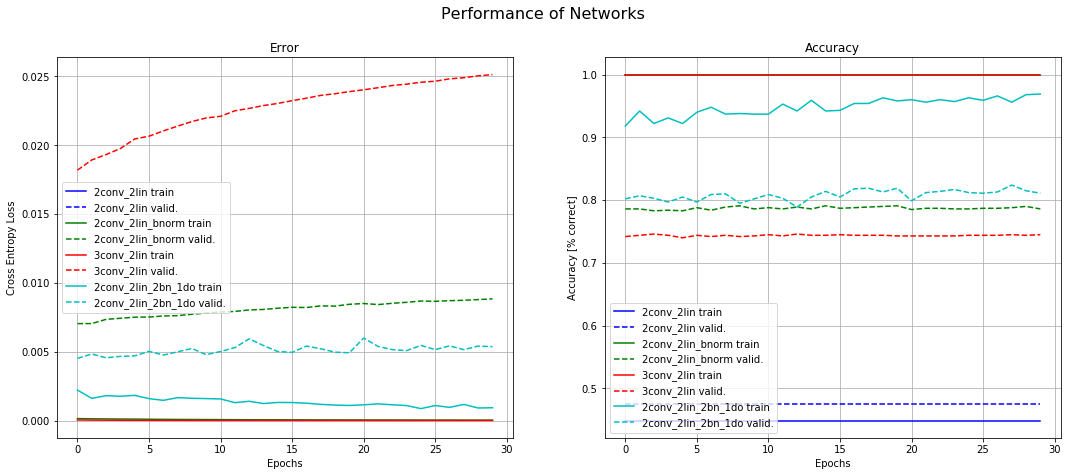

In [11]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure('History Plot', figsize=(18,7))
fig.suptitle('Performance of Networks', fontsize=16)

ax1 = fig.add_subplot(121)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model.name()
    avg_loss_train = mod_perf.get_performance('train_loss')
    avg_loss_test = mod_perf.get_performance('test_loss')
    ax1.set_title('Error')
    ax1.plot(range(0,epochs), avg_loss_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax1.plot(range(0,epochs), avg_loss_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cross Entropy Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)

for i,mod_perf in enumerate(perf_summary):
    model_name = mod_perf.model.name()
    avg_acc_train = mod_perf.get_performance('train_accuracy')
    avg_acc_test = mod_perf.get_performance('test_accuracy')
    ax2.set_title('Accuracy')
    ax2.plot(range(0,epochs), avg_acc_train, linestyle='-', color=colors[i%8], label = model_name + ' train')
    ax2.plot(range(0,epochs), avg_acc_test, linestyle='--', color=colors[i%8], label = model_name + ' valid.')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy [% correct]')
ax2.grid()
ax2.legend();


Predicted Target: 1, Real Target: 1
Real classes are, left: 1 right: 2
Predicted Target: 0, Real Target: 0
Real classes are, left: 7 right: 1


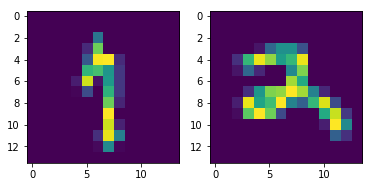

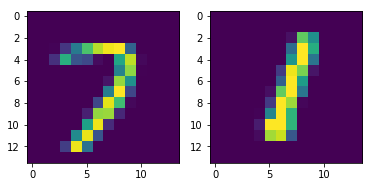

In [9]:
dataset_test.infere(model,5);
dataset_test.infere(model,6);